<img src="images/for-sale-sign.png" />

# King County House Price Model
---
**Authors:** Wes Newcomb, Noble Tang, Kelsey Lane

## Overview
---
This project analyzes housing information drawn from the King County area from May 2014 to May 2015 in order to help future home owners determine an estimated price to expect for property in the area. After the data were cleaned and encoded, various iterative multiple linear regressions were run in order to converge on a model to use for the house price inference. It was found that the price of a given home in King County could be reasonably modeled using square footage of the house, the number of bedrooms, and if the house was in an urban, suburban, or rural area.

## Business Problem
---
This model was created for home buyers looking in King County during 2016 to help them find an estimate for what to expect for house price by inputting criteria of interest in order to avoid unrealistically high prices (and conversely, capitalize on unrealistically low prices). Prospective home buyers in King County can know what price to expect to pay for a property of interest, and as a result, can better negotiate with large real estate conglomerates for a fair price. Ultimately, this model helps level the playing field by offering data to individual consumers that was once only available to large real estate companies. As a result, the modeled home prices help prospective buyers save time and stress in the high-pressure process from ideation to congratulations. 


## Data Understanding
---
This project uses a dataset containing information on 21,597 property sales in King County between May 2014 and May 2015 drawn from the [King County website](https://info.kingcounty.gov/assessor/esales/residential.aspx?openSearchForm=1). Each row represents a different sale and corresponding information about the property sold.

In [2]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# load dataset into notebook
df = pd.read_csv('data/kc_house_data.csv')

# preview dataset
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


The information provided includes details like the square footage of lot and living space, number of beds and bathrooms, the date the property sold and for how much, the number of floors in the house, if it was a waterfront property, the zip code the property is in, and other additional columns shown below.

In [3]:
# preview dataset columnar information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

As the model is predicting the price of future homes, price is the target variable used from the dataset. The distribution of the column can be seen below, where there is a right skew, indicating the presence of some very expensive homes in the dataset.

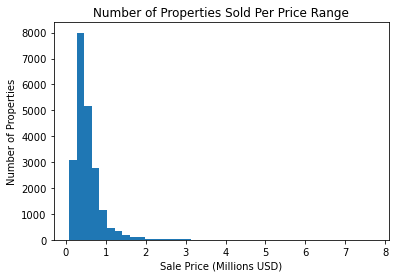

In [4]:
#Visualize home price data
ax1 = plt.axes()
(df['price']*(1/1000000)).hist(bins=40);
plt.ylabel('Number of Properties');
plt.xlabel('Sale Price (Millions USD)');
plt.title('Number of Properties Sold Per Price Range');
ax1.ticklabel_format(style='plain')
ax1.grid(False)
plt.show()

However, not all the information provided in the original dataset is used in the creation of the model. As [various](https://www.fortunebuilders.com/what-are-the-biggest-factors-in-determining-property-value/) [sources](https://www.mymove.com/buying-selling/guides/most-important-factors-for-buying-your-dream-home/) from the 2014-2015 time range point out, square footage of the house (sqft_living), number of bathrooms, number of bedrooms, location (zip code), square footage of the lot (sqft_lot), and home condition all seem to be important factors buyers consider when looking at a home. Therefore, these factors are narrowed in on when it comes to model creation. Furthermore, most of the continuous features in that list correlate well with the target variable, price, while not correlating strongly with each other, making them viable to use while avoiding any issues with multicollinearity.

<AxesSubplot:>

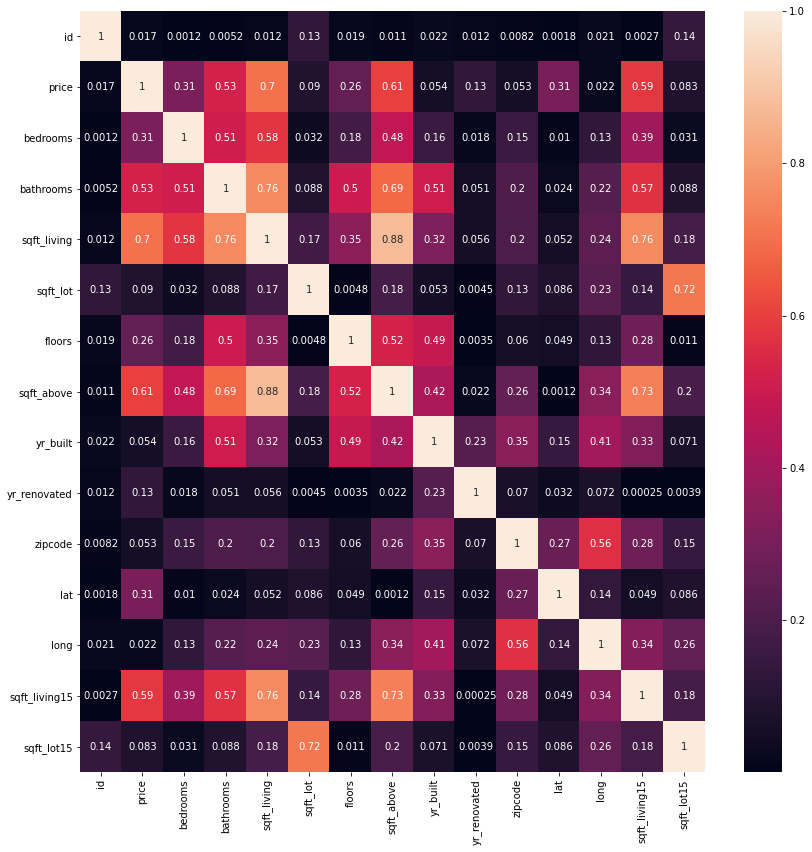

In [5]:
#Heatmap showing correlation with target and other continuous variables in dataset
fig, ax = plt.subplots(figsize=(14,14))
sns.heatmap(df.corr().abs(), annot = True)

## Data Preparation
---

### Outliers

While most of the data were entered correctly, there do appear to be some mistyped entries. An example is shown below, where one property is listed with 33 bedrooms while only having 1,620 square feet of living space, which isn't possible.

In [6]:
#Information on the misentered house
df.iloc[15856]

id               2402100895
date              6/25/2014
price                640000
bedrooms                 33
bathrooms              1.75
sqft_living            1620
sqft_lot               6000
floors                    1
waterfront               NO
view                   NONE
condition         Very Good
grade             7 Average
sqft_above             1040
sqft_basement         580.0
yr_built               1947
yr_renovated              0
zipcode               98103
lat                 47.6878
long               -122.331
sqft_living15          1330
sqft_lot15             4700
Name: 15856, dtype: object

Similarly, there are examples of data where the total amount of living space (sqft_living) exceeds the lot space of the property, even when floors are taken into account. This isn't possible, as it would mean the house is bigger than the lot it resides on.

In [7]:
#Shows the houses with impossible sizes
df[(df['sqft_lot']) < (df['sqft_living'] / df['floors'])]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1547,8816400885,10/8/2014,450000.0,4,1.75,1640,1480,1.0,NO,NONE,...,7 Average,820,820.0,1912,0.0,98105,47.6684,-122.314,1420,2342
3449,2559950110,4/22/2015,1230000.0,2,2.50,2470,609,3.0,NO,NONE,...,11 Excellent,1910,560.0,2011,0.0,98112,47.6182,-122.312,2440,1229
5795,2770604103,7/31/2014,450000.0,3,2.50,1530,762,2.0,NO,NONE,...,8 Good,1050,480.0,2007,0.0,98119,47.6420,-122.374,1610,1482
13240,2877104196,12/6/2014,760000.0,3,2.00,1780,1750,1.0,NO,AVERAGE,...,8 Good,1400,380.0,1927,2014.0,98103,47.6797,-122.357,1780,3750
13265,3277800845,7/11/2014,370000.0,3,1.00,1170,1105,1.0,NaN,NONE,...,7 Average,1170,0.0,1965,0.0,98126,47.5448,-122.375,1380,1399
15729,9828702895,10/22/2014,700000.0,4,1.75,2420,520,1.5,NO,NONE,...,7 Average,2420,0.0,1900,0.0,98112,47.6209,-122.302,1200,1170
16917,5016002275,6/2/2014,610000.0,5,2.50,3990,3839,1.0,NaN,NONE,...,8 Good,1990,2000.0,1962,0.0,98112,47.6236,-122.299,2090,5000
17420,2062600020,7/8/2014,530000.0,2,2.50,1785,779,2.0,NO,NONE,...,7 Average,1595,190.0,1975,0.0,98004,47.5959,-122.198,1780,794


Due to the fact that these nine listings don't seem to be possible and are likely present in the dataset due to humna error, they were dropped from the final dataset.

In [8]:
#Drops properties with more living space than possible
idx = df[(df['sqft_lot']) < (df['sqft_living'] / df['floors'])].index
df = df.drop(idx, axis=0)

#Drops property with 33 bedrooms and 1620 sqft_living
df = df.drop(15856, axis=0)

### Final Columns

As mentioned above, buyers care about certain property aspects over others. As a result, the dataset was paired down to only include the columns that buyers would be most interested in: square foot living space, bedrooms, bathrooms, sqaure footage of the lot, location (for now represented by zip code), home condition, and the year the house was built along if it was renovated.

In [9]:
#Drops the columns no longer needed
df = df.drop(columns = ['id', 'date', 'floors', 'waterfront', 'view', 'grade','lat', 
                        'long', 'sqft_basement', 'sqft_above', 'sqft_living15', 'sqft_lot15'])

### Missing Data

After selecting the final columns, there is some missing data left in the year renovated column.

In [10]:
df.isna().sum()

price              0
bedrooms           0
bathrooms          0
sqft_living        0
sqft_lot           0
condition          0
yr_built           0
yr_renovated    3842
zipcode            0
dtype: int64

As it is unclear if the null values indicate that the house wasn't renovated or that this information just wasn't collected, the safest approach seems to be to fill the empty value with the median value, which in this case is 0 indicating the property wasn't renovated.

In [33]:
df['yr_renovated'] = df['yr_renovated'].fillna(0)
df.isna().sum()

KeyError: 'yr_renovated'

### Column Creation

As location is one of the points of interest in the analysis, but the zip code column has too many variables to reasonably encode for an inferential model, the zip codes are categorized by being in an urban, suburban, or rural area. The information for this zip code breakdown is drawn from the [King County site](https://kingcounty.gov/~/media/depts/executive/performance-strategy-budget/regional-planning/buildable-lands-report/king-county-buildable-lands-report-2014.ashx?la=en) itself, where rural areas are identified [through this webpage](https://web.archive.org/web/20150911054310/https://kingcounty.gov/services/rural-services/rural/community.aspx) and the mapping of rural, suburban, and urban areas to zip code is obtained by comparing the first map to [the map of zip codes](https://kingcounty.gov/~/media/operations/GIS/maps/vmc/images/zipcodes_westKC_586.ashx?la=en%20-%20zipcode%20to%20place).

In [17]:
#Makes the zip code to location dictionary
zip_class = {
            98002 : 'Urban', 98092 : 'Urban', 98178: 'Urban', 98125: 'Urban', 98028:'Suburban',
            98136: 'Urban', 98074: 'Suburban', 98053: 'Urban', 98003: 'Urban',
            98198: 'Suburban', 98146: 'Urban', 98038: 'Suburban', 98007:'Urban', 98115:'Urban',
            98107:'Urban', 98126:'Urban', 98019:'Rural', 98103:'Urban', 98133:'Urban', 98030: 'Urban',
            98119:'Urban', 98112:'Urban', 98052:'Urban', 98027:'Suburban', 98117:'Urban', 98058:'Urban',
            98001:'Urban', 98056:'Urban', 98166:'Urban', 98023:'Urban', 98070:'Rural',
            98148:'Urban', 98105:'Urban', 98042:'Suburban', 98008:'Urban', 98059:'Urban', 98122:'Urban',
            98144:'Urban', 98004:'Urban', 98005:'Urban', 98034:'Urban', 98075:'Suburban',98116:'Urban',
            98010:'Rural', 98118:'Urban', 98199:'Urban', 98040:'Suburban', 98032:'Urban',
            98045:'Rural', 98102:'Urban', 98077:'Rural', 98108:'Urban', 98168:'Urban',
            98177:'Suburban', 98065:'Rural', 98029:'Suburban', 98006:'Urban', 98109:'Urban', 98022:'Rural',
            98033:'Urban', 98155:'Suburban', 98024:'Rural', 98011:'Urban', 98031:'Urban',
            98106:'Urban', 98072:'Suburban', 98188:'Urban', 98014:'Rural', 98055:'Urban', 98039:'Suburban'
            }
#Creates area column and assigns appropriate value based on zipcode
df['area_type'] = df['zipcode']
df['area_type'] = df['area_type'].map(zip_class)

#Drops zip code as it is no longer needed
df = df.drop('zipcode', axis = 1)
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,condition,yr_built,yr_renovated,area_type
0,221900.0,3,1.00,1180,5650,Average,1955,0.0,Urban
1,538000.0,3,2.25,2570,7242,Average,1951,1991.0,Urban
2,180000.0,2,1.00,770,10000,Average,1933,0.0,Suburban
3,604000.0,4,3.00,1960,5000,Very Good,1965,0.0,Urban
4,510000.0,3,2.00,1680,8080,Average,1987,0.0,Suburban


Finally, when renovation is considered in the iterative models below, it is treated as a true/false value where only the fact that the house was renovated matters. This is to help keep the model simple and also because it is ambiguous over how renovations could be accurately binned without introducing any confounding factors.

In [21]:
#Makes list to store if the house was renovated
is_renovated = []

#Cycles through the year renovated column and adds a one if the house was renovated, 0 if not
for value in df['yr_renovated']:
    if value > 0:
        is_renovated.append(1)
    else:
        is_renovated.append(0)

#Creates column denoting if house was or wasn't renovated and removes yr_renovated
df['is_renovated'] = is_renovated
df = df.drop('yr_renovated', axis = 1)
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,condition,yr_built,area_type,is_renovated
0,221900.0,3,1.00,1180,5650,Average,1955,Urban,0
1,538000.0,3,2.25,2570,7242,Average,1951,Urban,1
2,180000.0,2,1.00,770,10000,Average,1933,Suburban,0
3,604000.0,4,3.00,1960,5000,Very Good,1965,Urban,0
4,510000.0,3,2.00,1680,8080,Average,1987,Suburban,0


## Baseline Model
---

The baseline used for comparison of the models is the mean of the price. This is the simplest predictor, and thus works as a good measure of comparison to see if the future models have any kind of inferential power.

In [34]:
from sklearn.dummy import DummyRegressor

#Df to sample from for training and testing set
df_sample = df

df_train = df_sample.sample(frac=0.5, random_state=2)
df_test = df_sample.drop(df_train.index)

X_train = df_train.drop('price', axis=1)
y_train = df_train['price']

X_test = df_test.drop('price', axis=1)
y_test = df_test['price']

dummy_regr = DummyRegressor(strategy='mean')
dummy_regr.fit(X_train, y_train)
dummy_regr.predict(X_train)
print("Baseline R2: " + str(dummy_regr.score(X_test, y_test)))

Baseline R2: -5.592480262373023e-05


## Modeling and Evaluation
---

In order to make the modeling more efficient, the function below is used to generate the models. Briefly, it takes in a train-test split, if the independant variables are going to be scaled, and the names of continuous variables to know which columns to scale if appliable. The necessary inputs are then scaled if needed, the model is generated, the assumption tests are run, and the final model is returned.

In [44]:
#Imports necessary functions
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import Ridge
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot
from sklearn.metrics import mean_squared_error
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
pd.options.mode.chained_assignment = None

def model_maker(X_train, X_test, y_train, y_test, X_cont, scale = True):
    #Gets figures ready for plotting
    fig, axes = plt.subplots(nrows = 2, figsize = (12,12))
    
    #Scales data if needed
    if scale == True:
        scalar = StandardScaler()
        X_train[X_cont] = scalar.fit_transform(X_train[X_cont])
        X_test[X_cont] = scalar.transform(X_test[X_cont])
    
    #Makes model
    X_const = sm.add_constant(X_train)
    linreg_model = sm.OLS(y_train, X_train).fit()
    
    #Grabs predictions
    train_predict = linreg_model.predict(X_train)
    test_predict = linreg_model.predict(X_test)
    
    #Prints MSE
    print("Train MSE: " + str(mean_squared_error(y_train, train_predict)))
    print("Test MSE: " + str(mean_squared_error(y_test, test_predict)))
    
    #Creates residuals
    train_resid = y_train - train_predict
    test_resid = y_test - test_predict
    
    #Test for normality
    sm.qqplot(train_resid, line = 'r', ax = axes[0])
    
    #Test for heteroskedasticity
    model = Ridge()
    visualizer = ResidualsPlot(model, ax = axes[1])
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()
     
    return linreg_model

### First model
The first model looked at considers what seems to be the two most important factors to buyers based on the sources above - square foot living space and number of bathrooms.
**Add in why treat bathroom/bedroom as continuous?**

Model R2: 0.16000660425671032
Train MSE: 365204642459.9775
Test MSE: 350703089728.4005


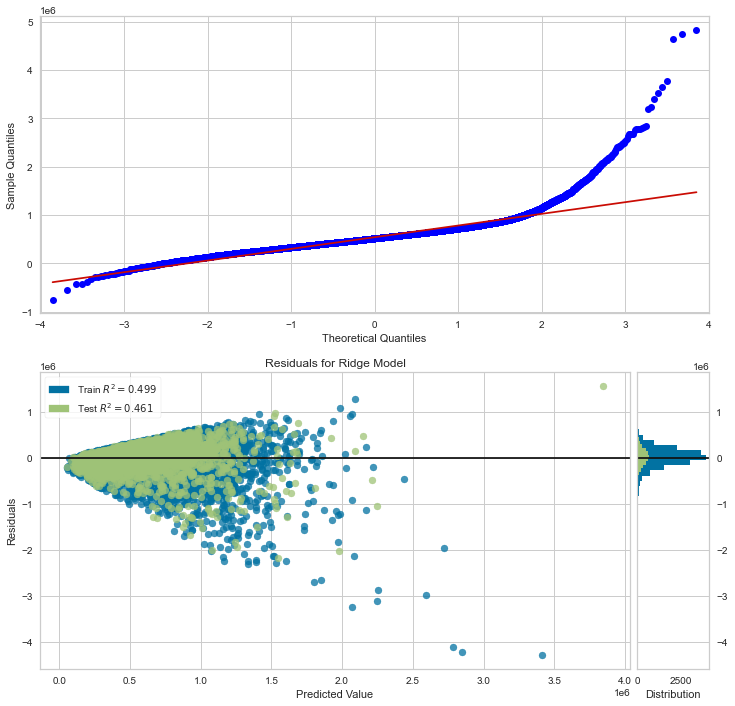

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.160
Model:                            OLS   Adj. R-squared (uncentered):              0.160
Method:                 Least Squares   F-statistic:                              1646.
Date:                Wed, 06 Oct 2021   Prob (F-statistic):                        0.00
Time:                        12:31:33   Log-Likelihood:                     -2.5440e+05
No. Observations:               17270   AIC:                                  5.088e+05
Df Residuals:                   17268   BIC:                                  5.088e+05
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
bathrooms   -4417.6539   7050.011     -0.627      0.531   -1.82e+04    9401.082
sqft_living  2.672e+05   7050.011     37.898      0.000    2.53e+05    2.81e+05
==============================================================================
Omnibus:                    12148.279   Durbin-Watson:                   0.383
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           483241.210
Skew:                           2.903   Prob(JB):                         0.00
Kurtosis:                      28.256   Cond. No.                         2.69
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
#Grabs continuous variable names
features_of_interest = ['bathrooms', 'sqft_living']

#Creates independant and dependant variables
X_df = df[features_of_interest]
y_df = df['price']

#Train test splits the data
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=69)

#Makes the model and runs assumption tests
first_model = model_maker(X_train, X_test, y_train, y_test, features_of_interest)
first_model.summary()

### Second model
While the Adjusted R2 value for this first model is better than the baseline, bathrooms does not seem to be a significant predictor despite correlating well with price. Therefore, the next model swaps out bathrooms for bedrooms as a predictor, which is another important factor buyers consider that also seems to correlate well with price.

Model R2: 0.1651010284827693
Train MSE: 362989735310.17664
Test MSE: 348310084760.0081


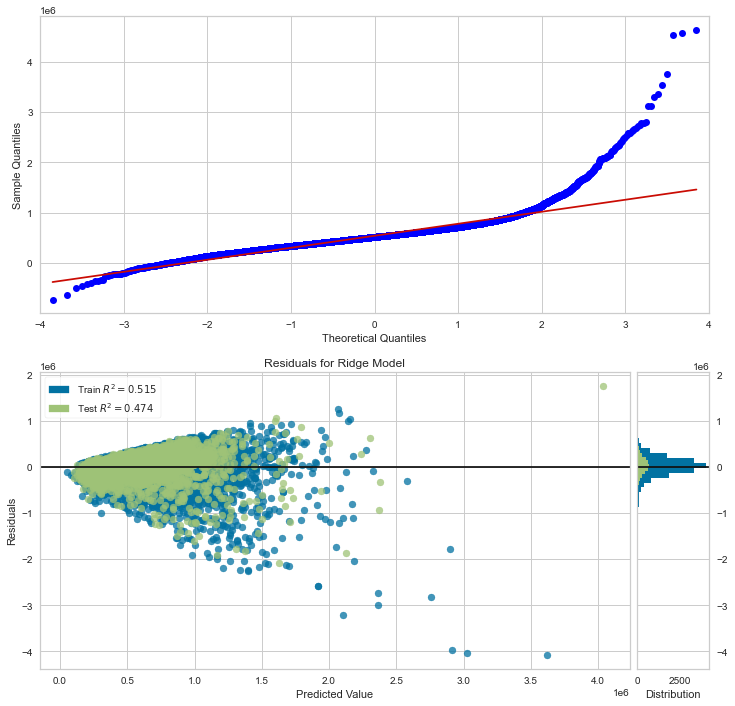

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.165
Model:                            OLS   Adj. R-squared (uncentered):              0.165
Method:                 Least Squares   F-statistic:                              1709.
Date:                Wed, 06 Oct 2021   Prob (F-statistic):                        0.00
Time:                        12:39:09   Log-Likelihood:                     -2.5435e+05
No. Observations:               17270   AIC:                                  5.087e+05
Df Residuals:                   17268   BIC:                                  5.087e+05
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
sqft_living  2.985e+05   5689.039     52.464      0.000    2.87e+05     3.1e+05
bedrooms    -5.851e+04   5689.039    -10.284      0.000   -6.97e+04   -4.74e+04
==============================================================================
Omnibus:                    11750.041   Durbin-Watson:                   0.372
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           425990.817
Skew:                           2.790   Prob(JB):                         0.00
Kurtosis:                      26.683   Cond. No.                         1.98
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
#The features we are interested in for this model
features_of_interest = ['sqft_living', 'bedrooms']

#New independant variable dataframe
X_df = df[features_of_interest]

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=69)

second_model = model_maker(X_train, X_test, y_train, y_test, features_of_interest)
second_model.summary()

### Third model
While the adujsted R2 value is only slightly better than the first model, both coefficients this time are significant. Therefore, this model is the one iterated on as it includes the two coefficients that correlate highly with price and are important to home buyers. From here, the next model includes location in an effort to better explain the variability in price and thus improve the adjusted R2 score. This also improves its usefulness for home buyers looking for a house in a specific type of area. As location is treated as a categorical variable, it is one hot encoded and the rural column is dropped to avoid multicollinearity issues.

Model R2: 0.8187863883963002
Train MSE: 78777270772.27304
Test MSE: 71607070848.56537


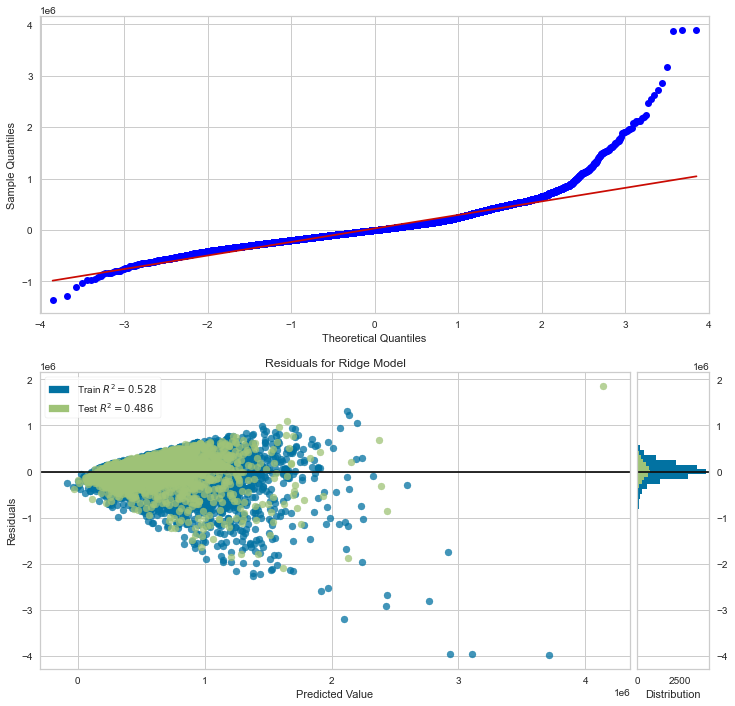

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.819
Model:                            OLS   Adj. R-squared (uncentered):              0.819
Method:                 Least Squares   F-statistic:                          1.951e+04
Date:                Wed, 06 Oct 2021   Prob (F-statistic):                        0.00
Time:                        12:57:30   Log-Likelihood:                     -2.4116e+05
No. Observations:               17270   AIC:                                  4.823e+05
Df Residuals:                   17266   BIC:                                  4.824e+05
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
area__Suburban  5.039e+05   4702.976    107.153      0.000    4.95e+05    5.13e+05
area__Urban     5.683e+05   2533.814    224.278      0.000    5.63e+05    5.73e+05
sqft_living     3.172e+05   2673.088    118.666      0.000    3.12e+05    3.22e+05
bedrooms       -7.068e+04   2651.123    -26.659      0.000   -7.59e+04   -6.55e+04
==============================================================================
Omnibus:                     8858.629   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           166788.079
Skew:                           2.033   Prob(JB):                         0.00
Kurtosis:                      17.672   Cond. No.                         2.79
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [39]:
#The features we are interested in for this model
features_of_interest = ['sqft_living', 'bedrooms']

#Categorical data that we want to include in our model
city_df = pd.get_dummies(df['area_type'], drop_first=True, prefix='area_')

#Creates new dataframe of independant variables
X_df = pd.concat([city_df, df[features_of_interest]], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=69)

third_model = model_maker(X_train, X_test, y_train, y_test, features_of_interest)
third_model.summary()

### Fourth model
This third model has a drastic increase in the adjusted R2 value, hopping up from around 16% to now explaining almost 82% of the variability in price. All coefficients also remain significant, indicating they would be good predictors to use. However, there are issues with both the homoskedasticity and normality assumptions. In an effort to address this, the next model eliminates houses with a price outside three standard deviations from the mean based on the training data from both the train and test sets. This should help decrease the effect of home price outliers on the data and help correct some issues with the model.

Model R2: 0.8325855228253765
Train MSE: 65339153965.940575
Test MSE: 65634356867.971565


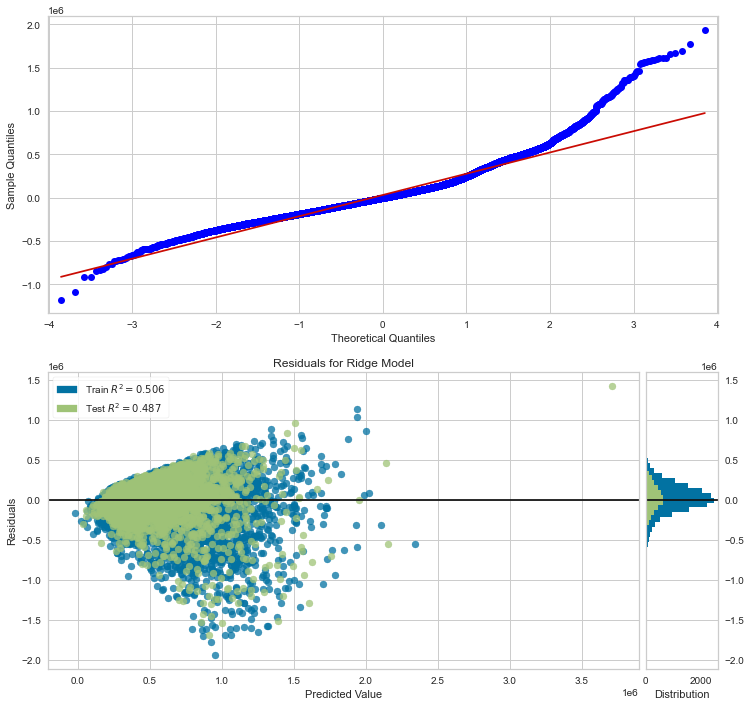

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.833
Model:                            OLS   Adj. R-squared (uncentered):              0.833
Method:                 Least Squares   F-statistic:                          2.141e+04
Date:                Wed, 06 Oct 2021   Prob (F-statistic):                        0.00
Time:                        13:03:18   Log-Likelihood:                     -2.3882e+05
No. Observations:               17218   AIC:                                  4.776e+05
Df Residuals:                   17214   BIC:                                  4.777e+05
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
area__Suburban  4.987e+05   4293.051    116.160      0.000     4.9e+05    5.07e+05
area__Urban     5.559e+05   2311.487    240.500      0.000    5.51e+05     5.6e+05
sqft_living     2.711e+05   2443.145    110.983      0.000    2.66e+05    2.76e+05
bedrooms       -5.782e+04   2422.368    -23.868      0.000   -6.26e+04   -5.31e+04
==============================================================================
Omnibus:                     4245.342   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15162.689
Skew:                           1.213   Prob(JB):                         0.00
Kurtosis:                       6.905   Cond. No.                         2.80
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
#The continuous features we are interested in for this model
features_of_interest = ['sqft_living', 'bedrooms']

X_df = pd.concat([city_df, df[features_of_interest]], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=69)

#Merges training and testing sets together
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

#Finds the price cutoff based on training and applies to both train/test sets
price_cutoff = train['price'].quantile(0.997)
train = train[train['price'] < price_cutoff]
test = test[test['price'] < price_cutoff]

#Splits data back in x and y
X_train = train.drop(columns='price')
y_train = train['price']

X_test = test.drop(columns='price')
y_test = test['price']

fourth_model = model_maker(X_train, X_test, y_train, y_test, features_of_interest)
fourth_model.summary()

### Fifth model
This fourth model shows a slight increase in adjusted R2 after cutting out the outliers, increasing by around 2%. Furthermore, compared to the third model with the same predictors, there is a lower mean squared error with less of a difference between the training and test sets, indicating this model does a better job than the earlier one. While this is the final model settled on, further iterations were done with other inputs to see if there would be a pursuable increase in adjusted R2. For the sake of brevity, only one of the models is included as none of them are further pursued.

Train MSE: 64276475867.36284
Test MSE: 65006935930.9174


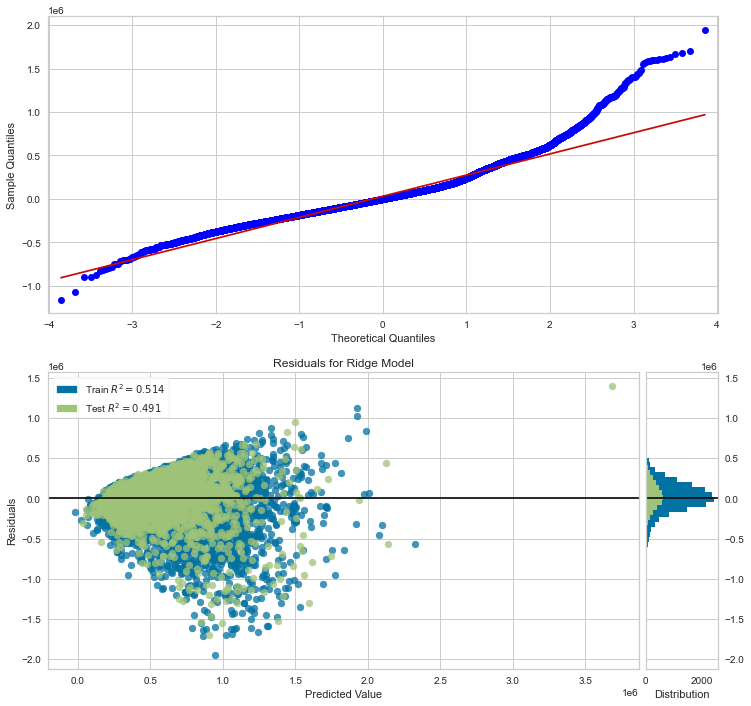

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.835
Model:                            OLS   Adj. R-squared (uncentered):              0.835
Method:                 Least Squares   F-statistic:                          1.747e+04
Date:                Wed, 06 Oct 2021   Prob (F-statistic):                        0.00
Time:                        14:19:16   Log-Likelihood:                     -2.3868e+05
No. Observations:               17218   AIC:                                  4.774e+05
Df Residuals:                   17213   BIC:                                  4.774e+05
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
area__Suburban  4.943e+05   4266.084    115.864      0.000    4.86e+05    5.03e+05
area__Urban     5.492e+05   2326.523    236.078      0.000    5.45e+05    5.54e+05
sqft_living      2.69e+05   2426.679    110.841      0.000    2.64e+05    2.74e+05
bedrooms       -5.711e+04   2403.020    -23.767      0.000   -6.18e+04   -5.24e+04
is_renovated    1.811e+05   1.07e+04     16.870      0.000     1.6e+05    2.02e+05
==============================================================================
Omnibus:                     4148.274   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14790.654
Skew:                           1.186   Prob(JB):                         0.00
Kurtosis:                       6.872   Cond. No.                         7.04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [45]:
# Unused model that includes the factors from the forth model + is_renovated

#the features we are interested in for this model
features_of_interest = ['sqft_living', 'bedrooms']

X_df = pd.concat([city_df, df[features_of_interest], df['is_renovated']], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=69)

#Filtering out the high priced outliers
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

price_cutoff = train['price'].quantile(0.997)
train = train[train['price'] < price_cutoff]
test = test[test['price'] < price_cutoff]

X_train = train.drop(columns='price')
y_train = train['price']

X_test = test.drop(columns='price')
y_test = test['price']

fifth_model = model_maker(X_train, X_test, y_train, y_test, features_of_interest)
fifth_model.summary()

## Final Model Evaluation
---

As mentioned earlier, the fourth model is the final model used as further iterations did not show a big enough increase in R2 to consider pursuing further. For interpretability, the fourth model is again included below, but this time with the continuous variables being unscaled. The takeaway for this model seems to be that location, square foot living space, and number of bedrooms can be used to explain around 87% of the variability of price for homes in King County from 2014-2015. This is an improvement on the baseline, whose R2 score was quite small, indicating this model does a much better job of explaining the variability. With everything else held steady, an increse in 1 sqaure foot living space increases price by around 292 dollars and adding an additional bedroom decreases price by 5,393 dollars. Other factors still held constant, living in an urban rather than rural area increases price by 131,300 dollars and living in a suburban area rather than rural increases price by 76,880 dollars. Of these factors, number of bedrooms is the most significant predictor, followed by urban and suburban areas and then square foot living.

When it comes to the model assumptions, the model does not do that well. While linearity and multicollinearity are checked before with the correlation plot and are accounted for, the QQ plot showing normality still has issues at the tail ends despite culling out outliers. Similarly, the plot looking at heteroskedasticity retains a cone shape, indiacting issues there as well.

While this is a decent fit for the dataset provided, it isn't clear how well it would generalize to different areas and different time periods, as house prices and price distribution would be affected by these factors. Therefore, the model would generalize beyond this data for areas with a similar culture to King County around this timeframe. As for how beneficial this model is for the stakeholders, given the adjusted R2 score of 87%, it would do a good job at helping predict home prices for home buyers looking in King County during 2016. As time goes on the market shifts and the model would become less accurrate, but given the stakeholder defined above this wouldn't be considered.

Model R2: 0.8666323536544854
Train MSE: 52051228338.845
Test MSE: 53986656891.385056


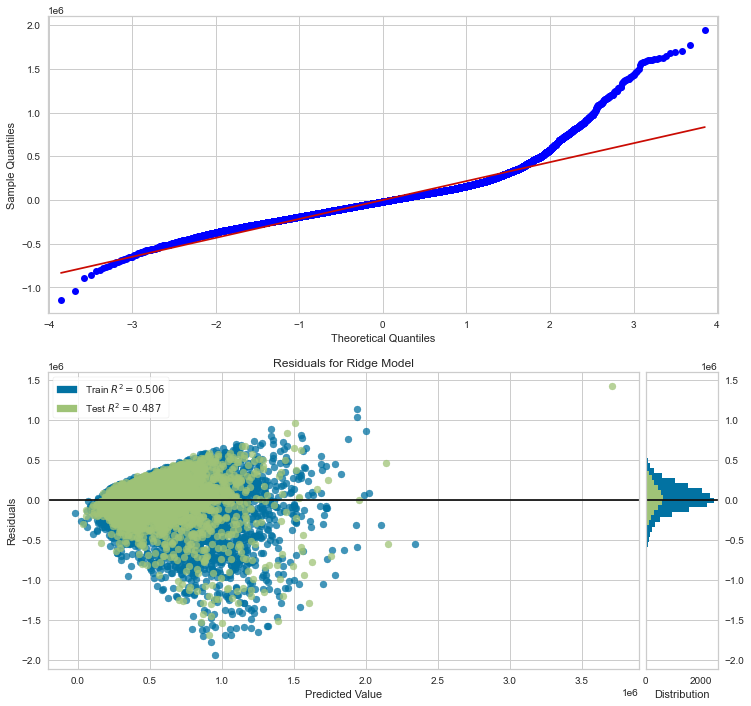

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.867
Model:                            OLS   Adj. R-squared (uncentered):              0.867
Method:                 Least Squares   F-statistic:                          2.797e+04
Date:                Wed, 06 Oct 2021   Prob (F-statistic):                        0.00
Time:                        13:13:47   Log-Likelihood:                     -2.3686e+05
No. Observations:               17218   AIC:                                  4.737e+05
Df Residuals:                   17214   BIC:                                  4.738e+05
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
area__Suburban  7.688e+04   6124.228     12.554      0.000    6.49e+04    8.89e+04
area__Urban     1.313e+05   5013.323     26.190      0.000    1.21e+05    1.41e+05
sqft_living      291.9512      2.458    118.768      0.000     287.133     296.769
bedrooms       -5.393e+04   2067.141    -26.089      0.000    -5.8e+04   -4.99e+04
==============================================================================
Omnibus:                     6541.466   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            47923.860
Skew:                           1.644   Prob(JB):                         0.00
Kurtosis:                      10.483   Cond. No.                     9.67e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 9.67e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [43]:
#the features we are interested in for this model
features_of_interest = ['sqft_living', 'bedrooms']

X_df = pd.concat([city_df, df[features_of_interest]], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=69)

#Filtering out the high priced homes, we want the lower 99.7%
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

#Finds the price cutoff based on training and applies to both train/test sets
price_cutoff = train['price'].quantile(0.997)
train = train[train['price'] < price_cutoff]
test = test[test['price'] < price_cutoff]

#Splits data back in x and y
X_train = train.drop(columns='price')
y_train = train['price']

X_test = test.drop(columns='price')
y_test = test['price']

fourth_model = model_maker(X_train, X_test, y_train, y_test, features_of_interest, scale = False)
fourth_model.summary()

## Conclusions
---
When home buyers are looking for a new home in the King County area during this timeframe, the number of bedrooms and location are the most important factors that will impact their home price, followed by square foot living. Therefore, when considering their budget, these factors should be adjusted first in order to save money if their desired home is out of their budget range. Furthermore, if home buyers are able to find a house listed under the predicted price, it would be a good deal to take advantage of.

Limitations of this data are obviously the timeframe and location, as home price prediction would vary based on these factors so this model wouldn't be applicable outside of this consideration. Building on that, the model is unstable for homes of a higher price and actually cuts off high-priced outliers, so buyers looking for more expensive or extravegant houses wouldn't get accurrate results. The model also doesn't include all the variables, so there may be factors influencing price that are overlooked, and factors home buyers care about that we don't include in the preidction and thus the model wouldn't cater to these people.

Finally, going forward it would be good to work with more data from different areas to see if the model could be adapted to different locations, as well as integrating data from more recent years.